Libraries:

In [1]:
import os
import gc
import itertools
import warnings
import cv2
import datetime
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from collections import Counter

import tensorflow as tf
from keras_drop_block import DropBlock2D
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

Parameteres:

In [2]:
batch_size = 128
epochs = 10
pic_size = 128
np.random.seed(42)
tf.random.set_seed(42)

Data path:

In [3]:
folder_path = r"D:/University/Ph. D. first term/Deep learning/HW3/Shoe vs Sandal vs Boot Dataset"

Part A:

Image ploting:

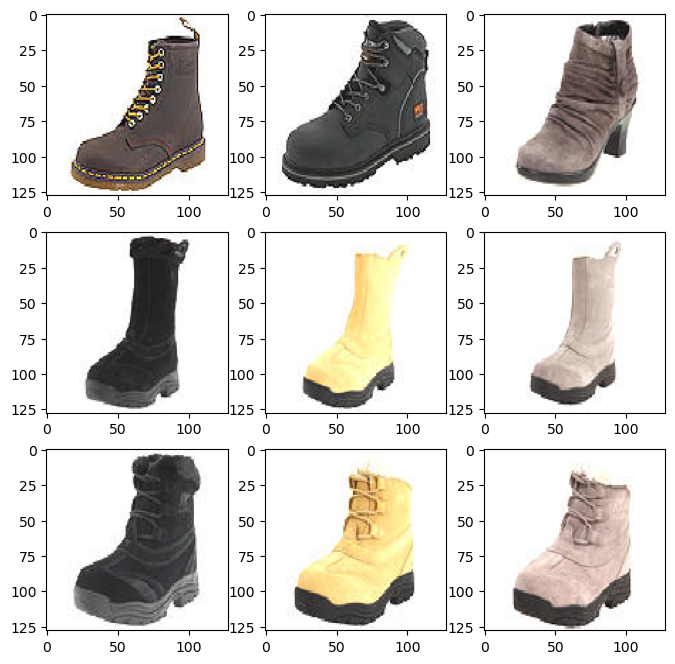

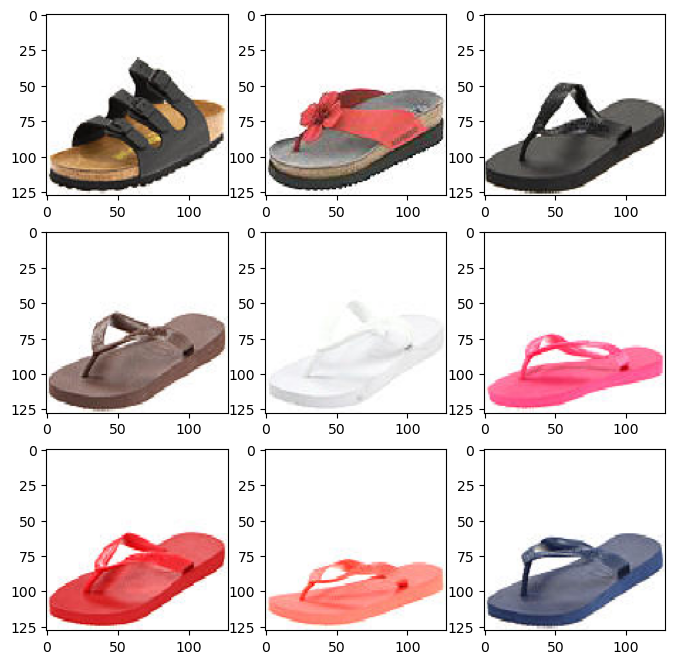

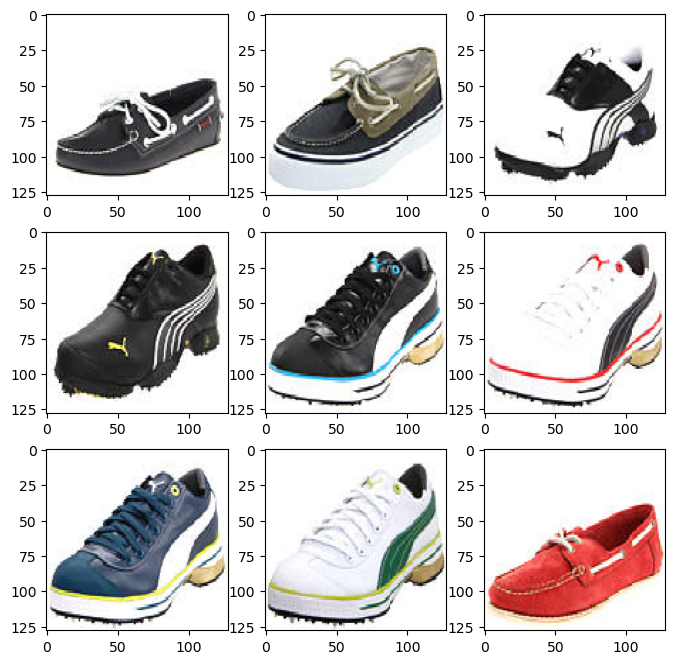

In [4]:
def plot_type(shoe):
    plt.figure(figsize= (8,8))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + '/' +shoe+'/'+
                       os.listdir(folder_path + '/' + shoe)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
        plt.grid(False)
    plt.show()
    
plot_type('@Boot')
plot_type('@Sandal')
plot_type('@Shoe')

Part B:

Preprocessing:

In [5]:
boot_sample = cv2.imread(r"D:/University/Ph. D. first term/Deep learning/HW3/Shoe vs Sandal vs Boot Dataset/@Boot/boot (1).jpg")
sandal_sample = cv2.imread(r"D:/University/Ph. D. first term/Deep learning/HW3/Shoe vs Sandal vs Boot Dataset/@Sandal/Sandal (1).jpg")
shoe_sample = cv2.imread(r"D:/University/Ph. D. first term/Deep learning/HW3/Shoe vs Sandal vs Boot Dataset/@Shoe/Shoe (1).jpg")

In [6]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
boot_sample = bgr2rgb(boot_sample)
sandal_sample = bgr2rgb(sandal_sample)
shoe_sample = bgr2rgb(shoe_sample)
samples = [boot_sample, sandal_sample, shoe_sample]

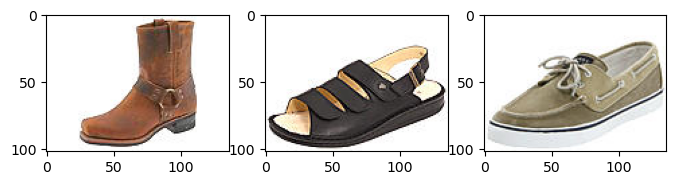

In [7]:
def plot_samples(samples, cmap, use_cmap=False):
    plt.figure(figsize= (8,8))
    for i in range(1, 4):
        plt.subplot(1,3,i)
        if use_cmap:
            plt.imshow(samples[i-1], cmap=cmap)
        else:
            plt.imshow(samples[i-1])
        plt.grid(False)
    plt.show()
plot_samples(samples, None)

In [8]:
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

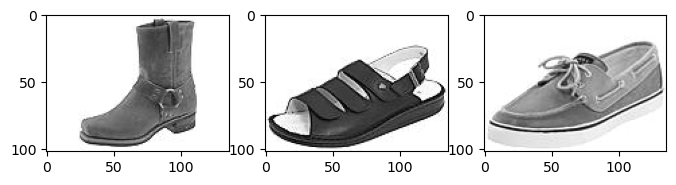

In [9]:
boot_sample = rgb2gray(boot_sample)
sandal_sample = rgb2gray(sandal_sample)
shoe_sample = rgb2gray(shoe_sample)
samples = [boot_sample, sandal_sample, shoe_sample]
plot_samples(samples, 'gray', use_cmap=True)

In [10]:
def edge_detection(img):
    return cv2.Canny(img , 90, 150)

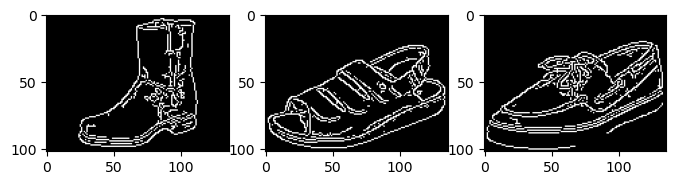

In [11]:
boot_sample_e = edge_detection(boot_sample)
sandal_sample_e = edge_detection(sandal_sample)
shoe_sample_e = edge_detection(shoe_sample)
samples_e = [boot_sample_e, sandal_sample_e, shoe_sample_e]
plot_samples(samples_e, 'gray', use_cmap=True)

In [12]:
def maping(img):
    return img/255

In [13]:
mapped = maping(boot_sample_e)
print(boot_sample_e[5])
print(mapped[5])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 255 255 255   0   0   0   0   0   0   0   0   0 255
 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


1 2 1


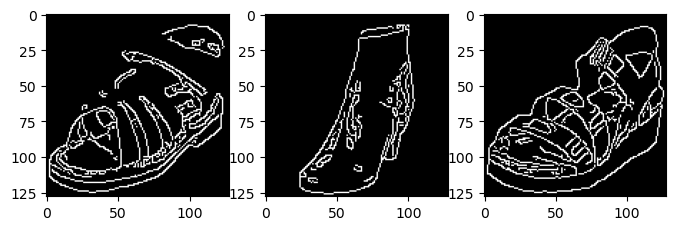

99750


In [14]:
dataset=[]
lab=[]
def walk_data(folder_path):
    global dataset
    global lab
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        for file in files:
            img = cv2.imread(root + '/' + file)
            img = cv2.resize(img, (pic_size, pic_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.Canny(img , 90, 150)
            img = img/255
            dataset.append(img)
            lab.append(root.split('@')[-1])
          

walk_data(folder_path)

dataset = np.array(dataset)
new_lab = []

for i in lab:
    tmp = None
    if i == 'Shoe':
        tmp = 0
    elif i == 'Sandal':
        tmp = 1
    elif i == 'Boot':
        tmp = 2
    
    new_lab.append(tmp)
        
new_lab = np.array(new_lab)
i = np.random.randint(0, 15000)
j = np.random.randint(0, 15000)
k = np.random.randint(0, 15000)
samples = [dataset[i], dataset[j], dataset[k]]
print(new_lab[i], new_lab[j], new_lab[k])
plot_samples(samples, 'gray',True)

x_train, x_test, y_train, y_test = train_test_split(dataset, new_lab, test_size=0.3, 
                                                    shuffle=True, random_state=42)
y_train_n = tf.keras.utils.to_categorical(y_train, 3)
y_test_n = tf.keras.utils.to_categorical(y_test, 3)
del dataset, lab
print(gc.collect())

In [15]:
def plot_history(history):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.legend(loc='lower right')
    plt.show()

Model structure:

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(pic_size, pic_size)),
    tf.keras.layers.MaxPool1D((4)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                          bias_initializer='zeros',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                          bias_initializer='zeros',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=32, activation='relu',
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                          bias_initializer='zeros',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Model fitting: (Part C is below of this section)

Epoch 1/10
83/83 [==============================] - 3s 24ms/step - loss: 0.9908 - accuracy: 0.6835 - val_loss: 0.6673 - val_accuracy: 0.8393
Epoch 2/10
83/83 [==============================] - 2s 18ms/step - loss: 0.6692 - accuracy: 0.8361 - val_loss: 0.5520 - val_accuracy: 0.8791
Epoch 3/10
83/83 [==============================] - 1s 17ms/step - loss: 0.5550 - accuracy: 0.8792 - val_loss: 0.4728 - val_accuracy: 0.9027
Epoch 4/10
83/83 [==============================] - 1s 17ms/step - loss: 0.4767 - accuracy: 0.8999 - val_loss: 0.4346 - val_accuracy: 0.9144
Epoch 5/10
83/83 [==============================] - 1s 17ms/step - loss: 0.4256 - accuracy: 0.9199 - val_loss: 0.4227 - val_accuracy: 0.9173
Epoch 6/10
83/83 [==============================] - 1s 17ms/step - loss: 0.3862 - accuracy: 0.9307 - val_loss: 0.4126 - val_accuracy: 0.9213
Epoch 7/10
83/83 [==============================] - 1s 16ms/step - loss: 0.3550 - accuracy: 0.9418 - val_loss: 0.4385 - val_accuracy: 0.9076
Epoch 8/10
83

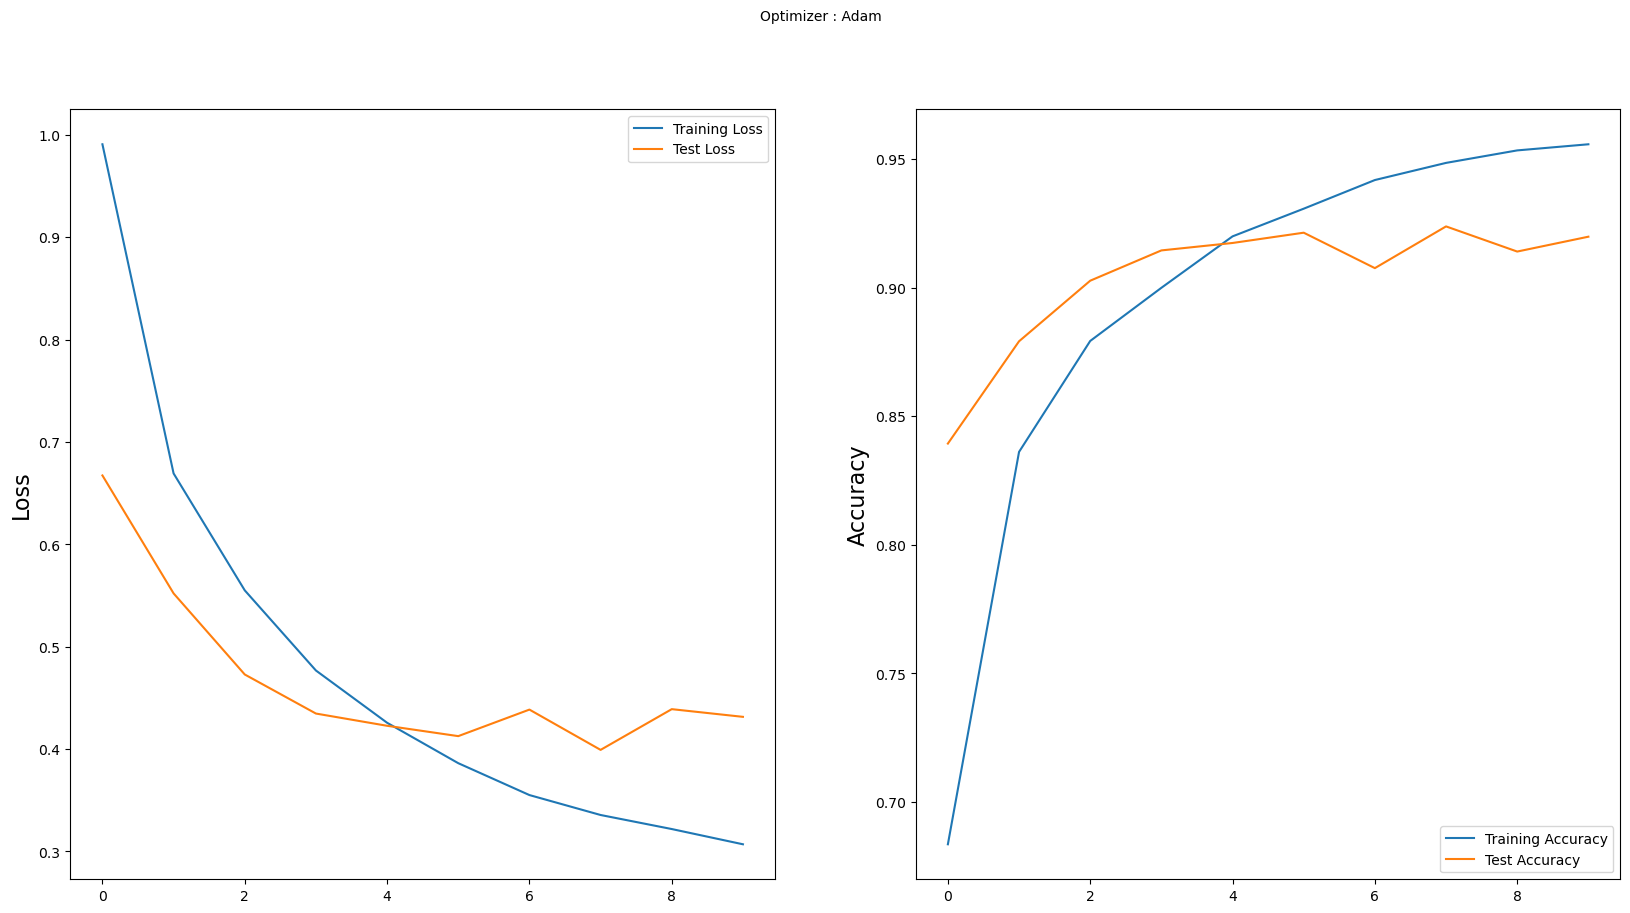

In [19]:
tf.keras.utils.plot_model(model, to_file='mlpmodel.png', show_shapes=True, show_layer_names=True)

manual_history = model.fit(x_train, y_train_n, validation_data=(x_test, y_test_n), epochs=epochs, batch_size=batch_size)
plot_history(manual_history)

141/141 [==============================] - 0s 3ms/step
The macro precision is:  0.9206093732142017
The micro precision is:  0.9197777777777778
The macro recall is:  0.9194320242444781
The micro recall is:  0.9197777777777778


<Figure size 640x480 with 0 Axes>

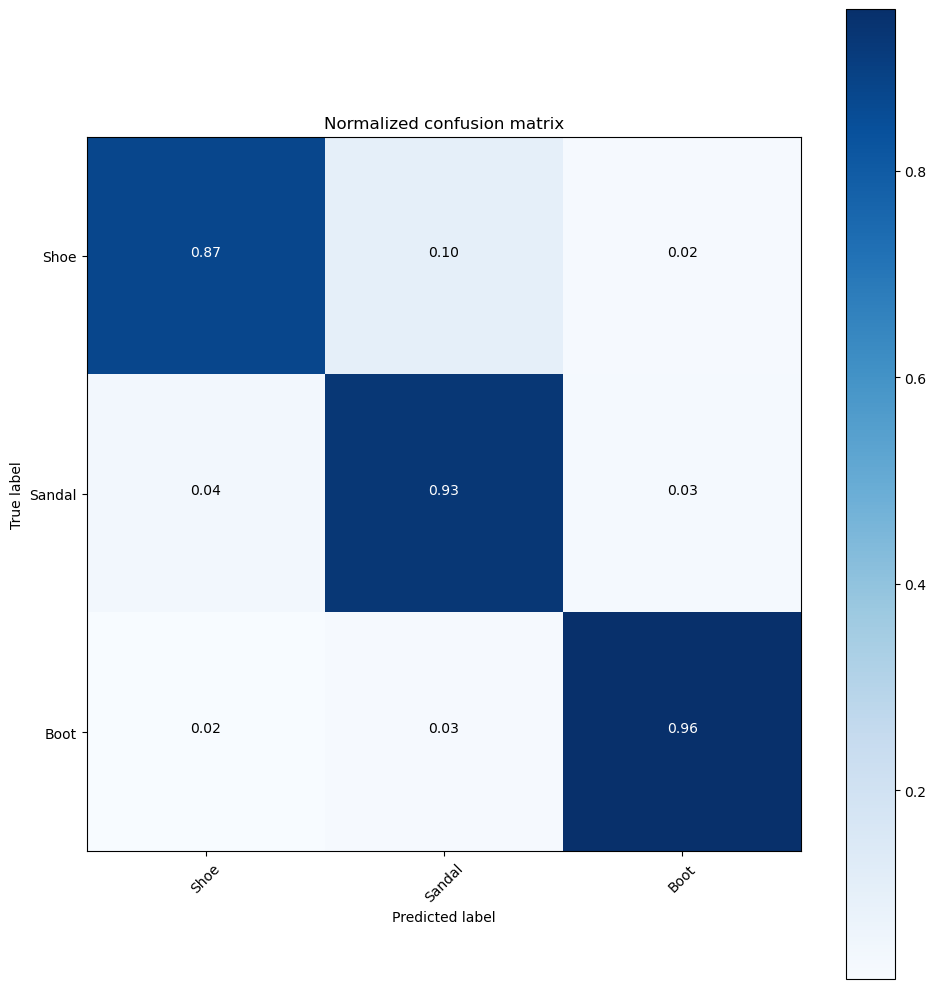

In [23]:
predictions = model.predict(x_test)
y_pred = [np.argmax(probas) for probas in predictions]
class_names = ['Shoe', 'Sandal', 'Boot']

precision_macro = precision_score(y_test, y_pred,average = 'macro')
print("The macro precision is: ", precision_macro)

precision_micro = precision_score(y_test, y_pred,average = 'micro')
print("The micro precision is: ", precision_micro)

recall = recall_score(y_test, y_pred, average = 'macro')
print("The macro recall is: ", recall)

recall = recall_score(y_test, y_pred, average = 'micro')
print("The micro recall is: ", recall)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Part D:

Data augmentation:

In [24]:
datagen  = ImageDataGenerator(validation_split=0.3)
train_set = datagen.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True, 
                                              subset='training'
                                       )
test_set = datagen.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False, 
                                              subset='validation'
                                       )

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


CNN model structure:

In [25]:
cnnmodel = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=32, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])

In [26]:
cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                      

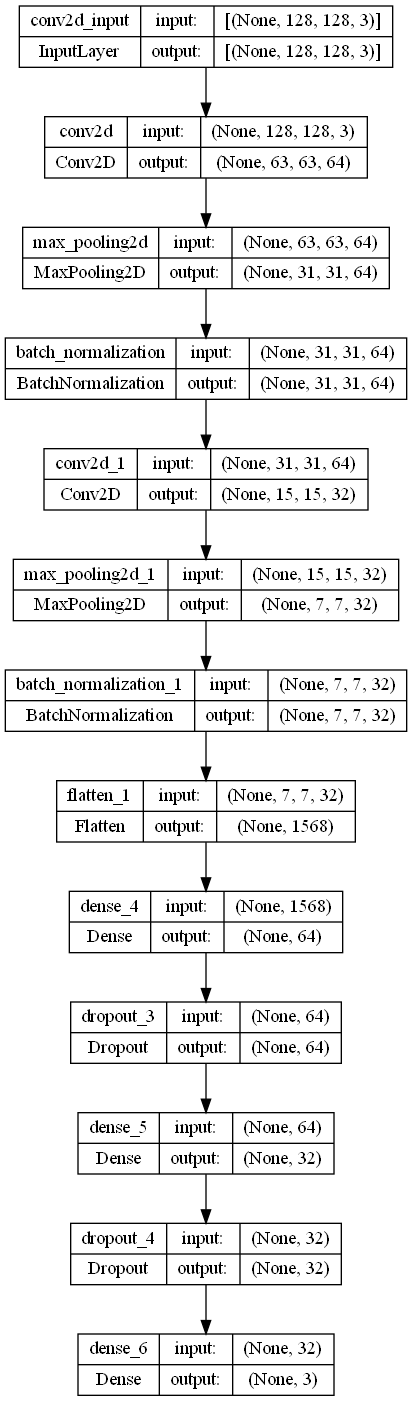

In [27]:
tf.keras.utils.plot_model(cnnmodel, to_file='cnnmodel.png', show_shapes=True, show_layer_names=True)

Model fitting:

In [28]:
cnnhistory = cnnmodel.fit(train_set, validation_data=test_set, epochs = epochs, batch_size = batch_size, verbose=1)

Epoch 1/10
83/83 [==============================] - 22s 246ms/step - loss: 3.4342 - accuracy: 0.7154 - val_loss: 4.4958 - val_accuracy: 0.4631
Epoch 2/10
83/83 [==============================] - 21s 249ms/step - loss: 1.7719 - accuracy: 0.8846 - val_loss: 1.3480 - val_accuracy: 0.8722
Epoch 3/10
83/83 [==============================] - 21s 257ms/step - loss: 1.0547 - accuracy: 0.9187 - val_loss: 0.9899 - val_accuracy: 0.8713
Epoch 4/10
83/83 [==============================] - 20s 238ms/step - loss: 0.7926 - accuracy: 0.9317 - val_loss: 0.7773 - val_accuracy: 0.9029
Epoch 5/10
83/83 [==============================] - 21s 251ms/step - loss: 0.6706 - accuracy: 0.9379 - val_loss: 0.6089 - val_accuracy: 0.9353
Epoch 6/10
83/83 [==============================] - 21s 254ms/step - loss: 0.5714 - accuracy: 0.9462 - val_loss: 0.5335 - val_accuracy: 0.9447
Epoch 7/10
83/83 [==============================] - 21s 257ms/step - loss: 0.6688 - accuracy: 0.9322 - val_loss: 0.6498 - val_accuracy: 0.9082

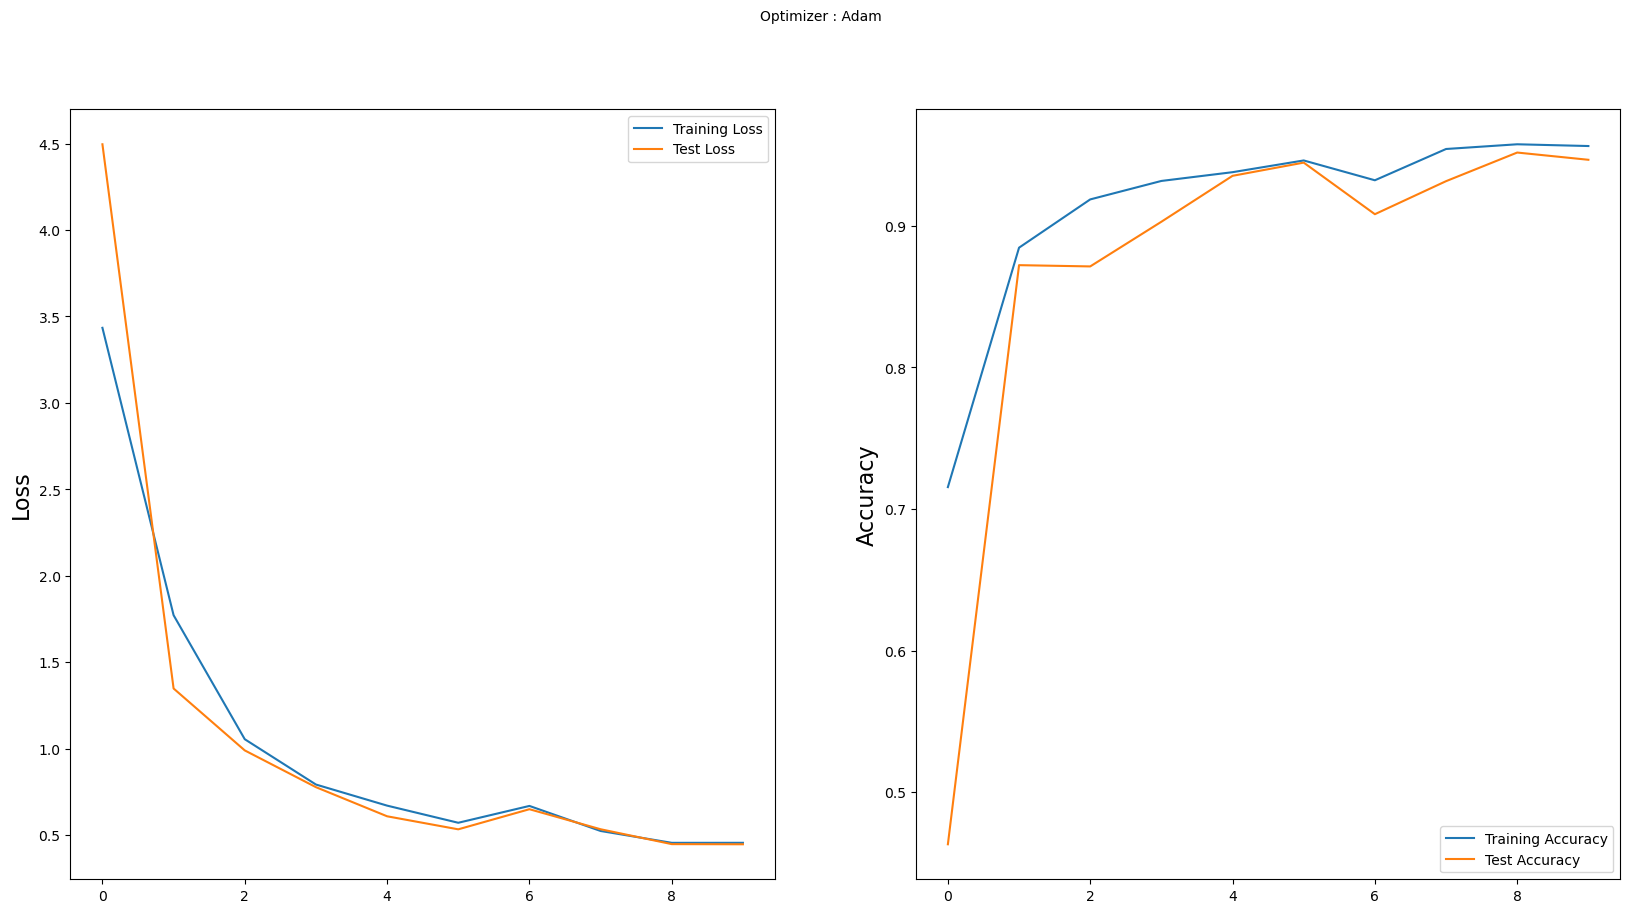

In [29]:
plot_history(cnnhistory)

In [30]:
predictions = cnnmodel.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

36/36 [==============================] - 5s 120ms/step


The accuracy of the test is:  0.9588888888888889
The macro precision is:  0.9596428040457069
The micro precision is:  0.9588888888888889
The macro recall is:  0.9588888888888888
The micro recall is:  0.9588888888888889


<Figure size 640x480 with 0 Axes>

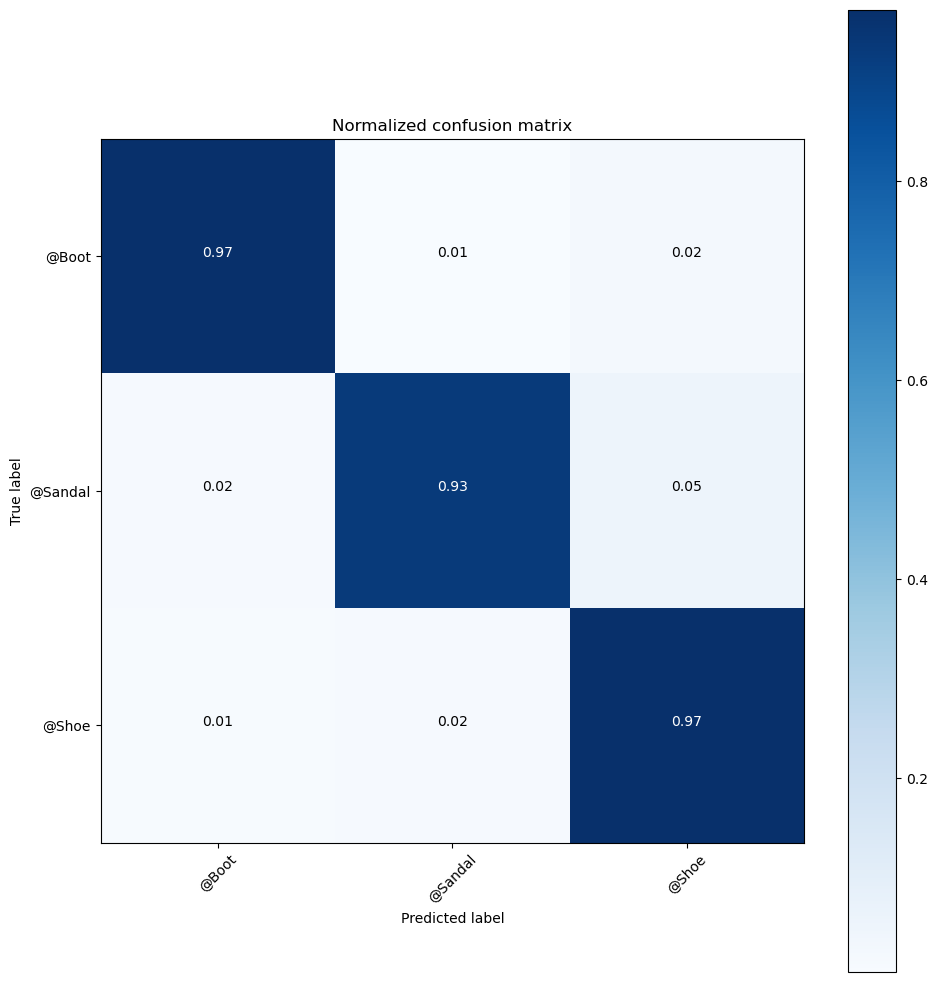

In [56]:
print('The accuracy of the test is: ', accuracy_score(y_test,y_pred))

precision_macro = precision_score(y_test, y_pred,average = 'macro')
print("The macro precision is: ", precision_macro)

precision_micro = precision_score(y_test, y_pred,average = 'micro')
print("The micro precision is: ", precision_micro)

recall = recall_score(y_test, y_pred, average = 'macro')
print("The macro recall is: ", recall)

recall = recall_score(y_test, y_pred, average = 'micro')
print("The micro recall is: ", recall)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Part H:
    We have better results with CNN  model. Becuase In the زدد model, we input the image into the network in the form of a matrix, and this makes it possible to maintain the connection of neighboring pixels and, as a result, to have better accuracy in image classification.

Part V:

In [41]:
cnnmodel = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    DropBlock2D(block_size=3, keep_prob=0.8, name='Dropout-1'),
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    DropBlock2D(block_size=3, keep_prob=0.8, name='Dropout-2'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dense(units=32, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])

In [42]:
cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                                 
 Dropout-1 (DropBlock2D)     (None, 31, 31, 64)        1922      
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 32)        

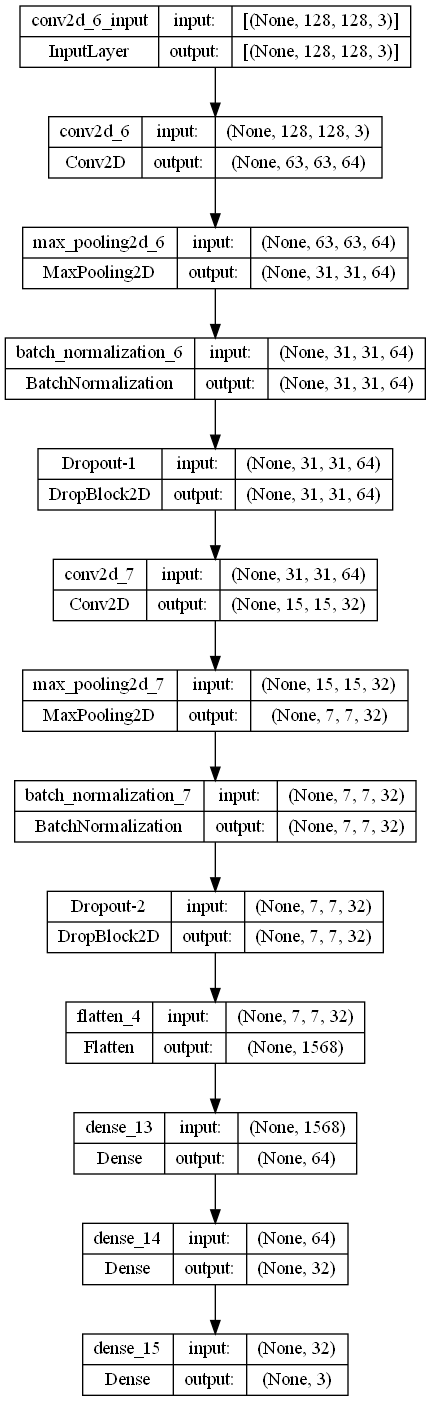

In [43]:
tf.keras.utils.plot_model(cnnmodel, to_file='cnnmodel.png', show_shapes=True, show_layer_names=True)

In [44]:
cnnhistory = cnnmodel.fit(train_set, validation_data=test_set, epochs = epochs, batch_size = batch_size, verbose=1)

Epoch 1/10
83/83 [==============================] - 28s 306ms/step - loss: 2.8682 - accuracy: 0.8537 - val_loss: 2.3684 - val_accuracy: 0.6816
Epoch 2/10
83/83 [==============================] - 28s 338ms/step - loss: 1.1859 - accuracy: 0.9292 - val_loss: 1.3223 - val_accuracy: 0.7589
Epoch 3/10
83/83 [==============================] - 26s 314ms/step - loss: 0.7011 - accuracy: 0.9419 - val_loss: 0.7046 - val_accuracy: 0.8920
Epoch 4/10
83/83 [==============================] - 26s 310ms/step - loss: 0.4975 - accuracy: 0.9584 - val_loss: 0.4826 - val_accuracy: 0.9493
Epoch 5/10
83/83 [==============================] - 28s 340ms/step - loss: 0.4064 - accuracy: 0.9616 - val_loss: 0.4242 - val_accuracy: 0.9420
Epoch 6/10
83/83 [==============================] - 26s 314ms/step - loss: 0.3531 - accuracy: 0.9640 - val_loss: 0.3775 - val_accuracy: 0.9533
Epoch 7/10
83/83 [==============================] - 26s 309ms/step - loss: 0.3268 - accuracy: 0.9643 - val_loss: 0.4438 - val_accuracy: 0.9160

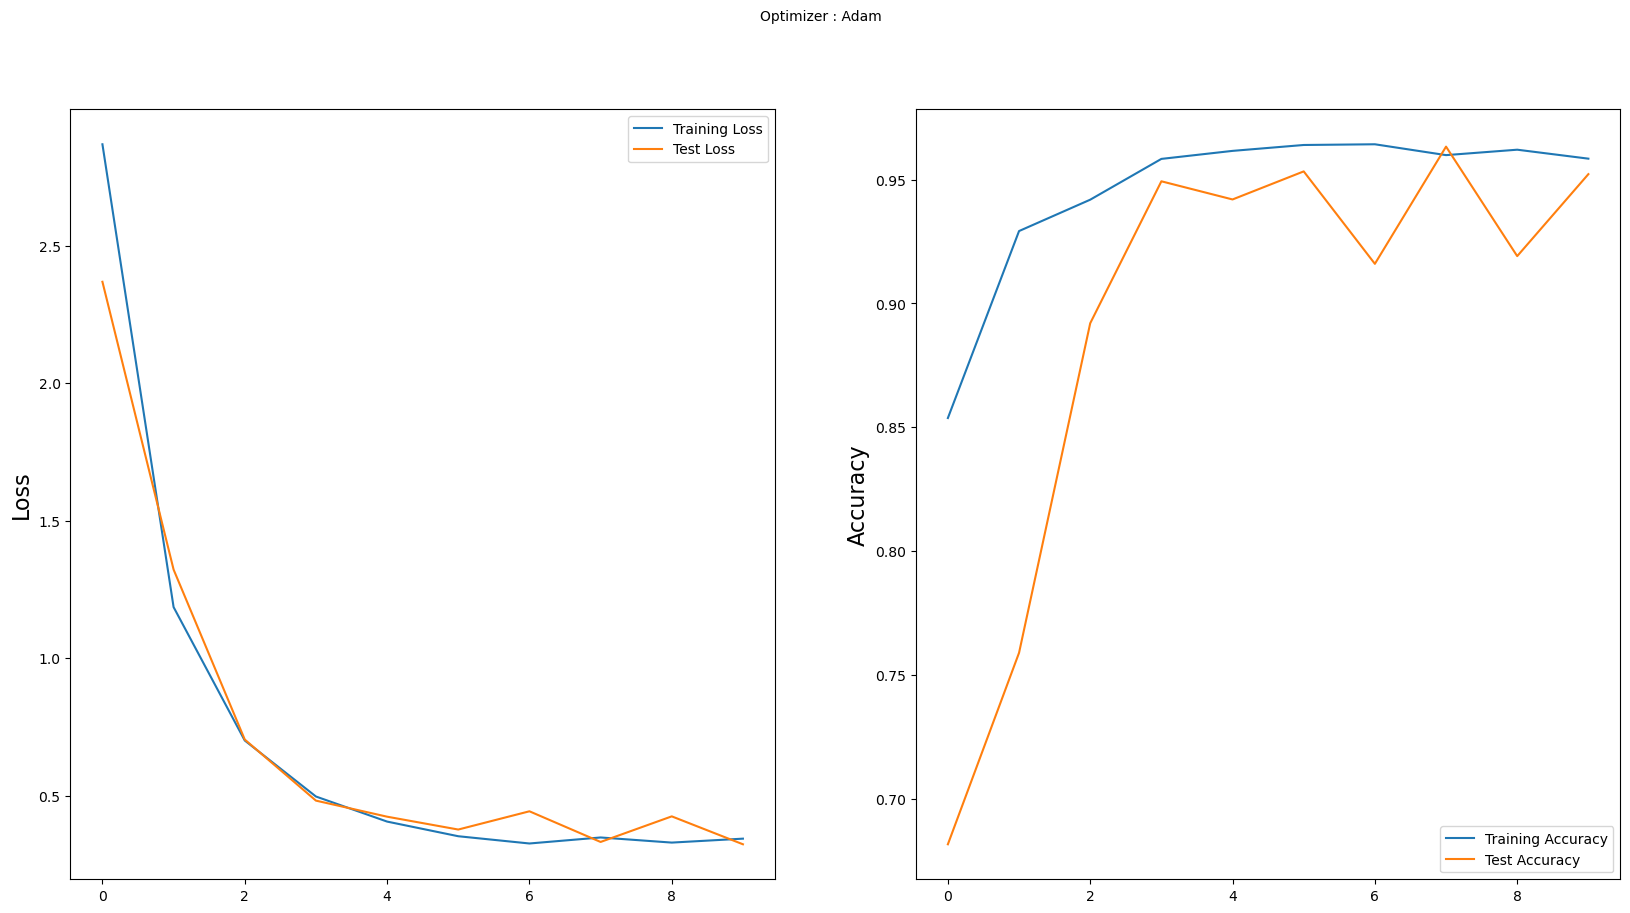

In [45]:
plot_history(cnnhistory)

In [46]:
predictions = cnnmodel.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

36/36 [==============================] - 4s 99ms/step


The accuracy of the test is:  0.9588888888888889
The macro precision is:  0.9596428040457069
The micro precision is:  0.9588888888888889
The macro recall is:  0.9588888888888888
The micro recall is:  0.9588888888888889


<Figure size 640x480 with 0 Axes>

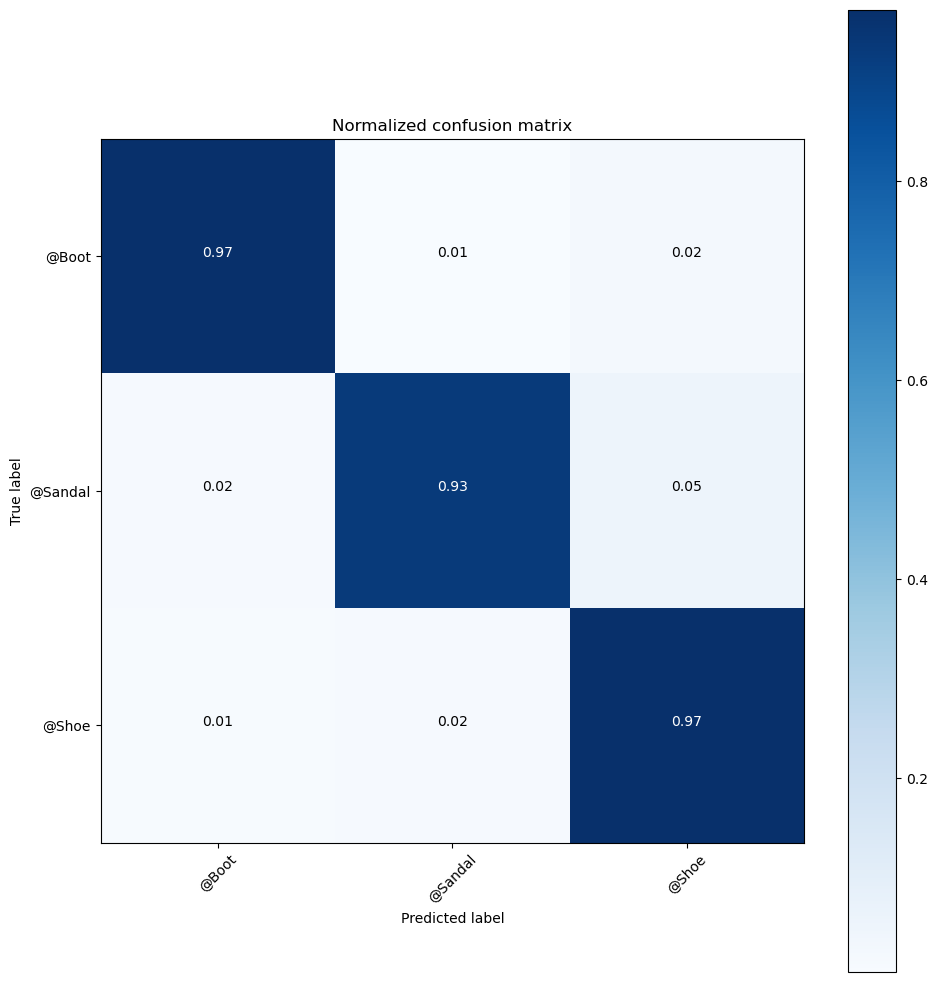

In [55]:
print('The accuracy of the test is: ', accuracy_score(y_test,y_pred))

precision_macro = precision_score(y_test, y_pred,average = 'macro')
print("The macro precision is: ", precision_macro)

precision_micro = precision_score(y_test, y_pred,average = 'micro')
print("The micro precision is: ", precision_micro)

recall = recall_score(y_test, y_pred, average = 'macro')
print("The macro recall is: ", recall)

recall = recall_score(y_test, y_pred, average = 'micro')
print("The micro recall is: ", recall)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Part Z:

In [48]:
cnnmodel = tf.keras.Sequential([
    
    tf.keras.layers.SeparableConv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    DropBlock2D(block_size=3, keep_prob=0.8, name='Dropout-1'),
    
    tf.keras.layers.SeparableConv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    DropBlock2D(block_size=3, keep_prob=0.8, name='Dropout-2'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dense(units=32, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])

In [49]:
cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 63, 63, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                                 
 Dropout-1 (DropBlock2D)     (None, 31, 31, 64)        1922      
                                                                 
 separable_conv2d_1 (Separab  (None, 15, 15, 32)       2656      
 leConv2D)                                            

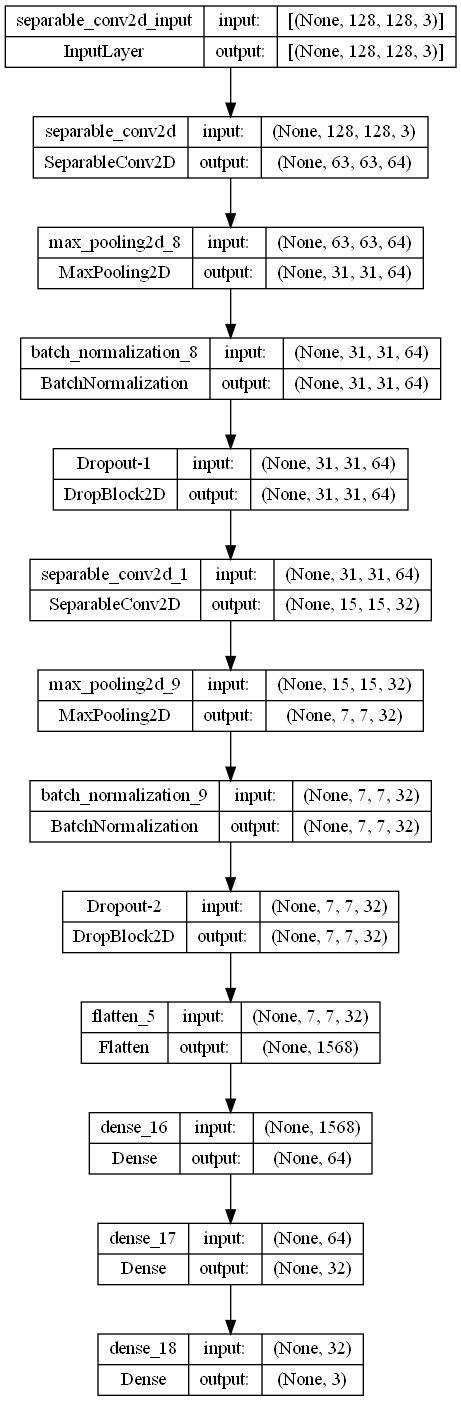

In [50]:
tf.keras.utils.plot_model(cnnmodel, to_file='cnnmodel.png', show_shapes=True, show_layer_names=True)

In [51]:
cnnhistory = cnnmodel.fit(train_set, validation_data=test_set, epochs = epochs, batch_size = batch_size, verbose=1)

Epoch 1/10
83/83 [==============================] - 28s 301ms/step - loss: 3.1090 - accuracy: 0.8306 - val_loss: 2.3364 - val_accuracy: 0.7302
Epoch 2/10
83/83 [==============================] - 24s 291ms/step - loss: 1.4698 - accuracy: 0.9089 - val_loss: 1.3061 - val_accuracy: 0.8713
Epoch 3/10
83/83 [==============================] - 26s 310ms/step - loss: 0.8856 - accuracy: 0.9329 - val_loss: 0.7662 - val_accuracy: 0.9327
Epoch 4/10
83/83 [==============================] - 27s 328ms/step - loss: 0.6353 - accuracy: 0.9412 - val_loss: 0.5852 - val_accuracy: 0.9342
Epoch 5/10
83/83 [==============================] - 29s 345ms/step - loss: 0.5220 - accuracy: 0.9463 - val_loss: 0.4932 - val_accuracy: 0.9484
Epoch 6/10
83/83 [==============================] - 29s 346ms/step - loss: 0.4681 - accuracy: 0.9492 - val_loss: 0.4862 - val_accuracy: 0.9342
Epoch 7/10
83/83 [==============================] - 25s 300ms/step - loss: 0.4109 - accuracy: 0.9528 - val_loss: 0.4014 - val_accuracy: 0.9538

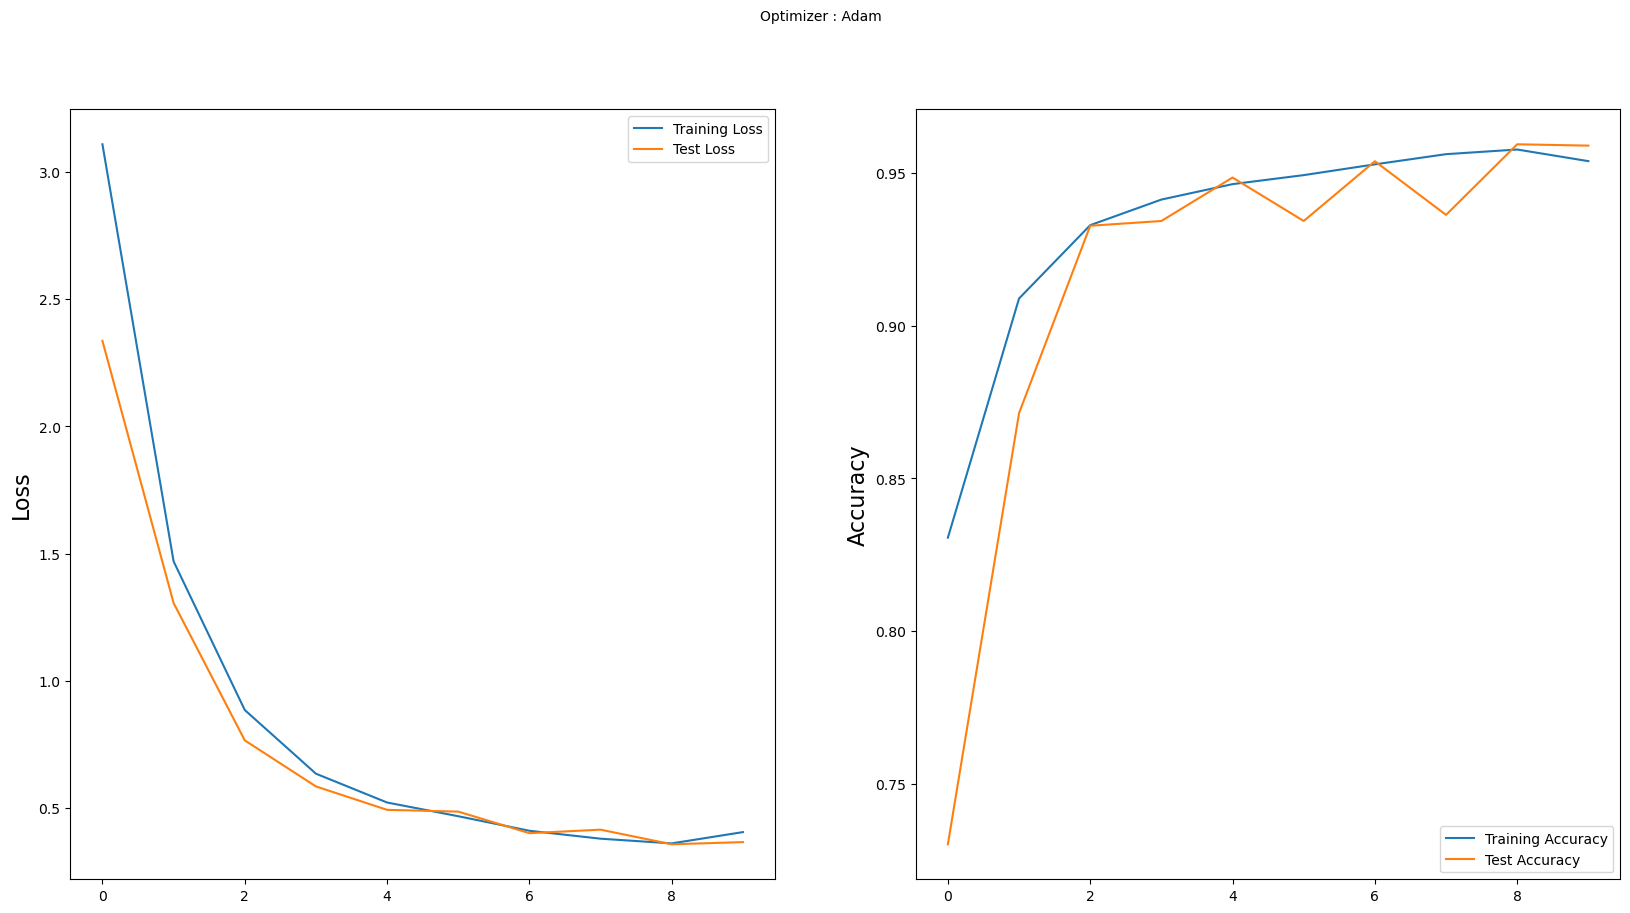

In [52]:
plot_history(cnnhistory)

In [53]:
predictions = cnnmodel.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

36/36 [==============================] - 4s 107ms/step


The accuracy of the test is:  0.9588888888888889
The macro precision is:  0.9596428040457069
The micro precision is:  0.9588888888888889
The macro recall is:  0.9588888888888888
The micro recall is:  0.9588888888888889


<Figure size 640x480 with 0 Axes>

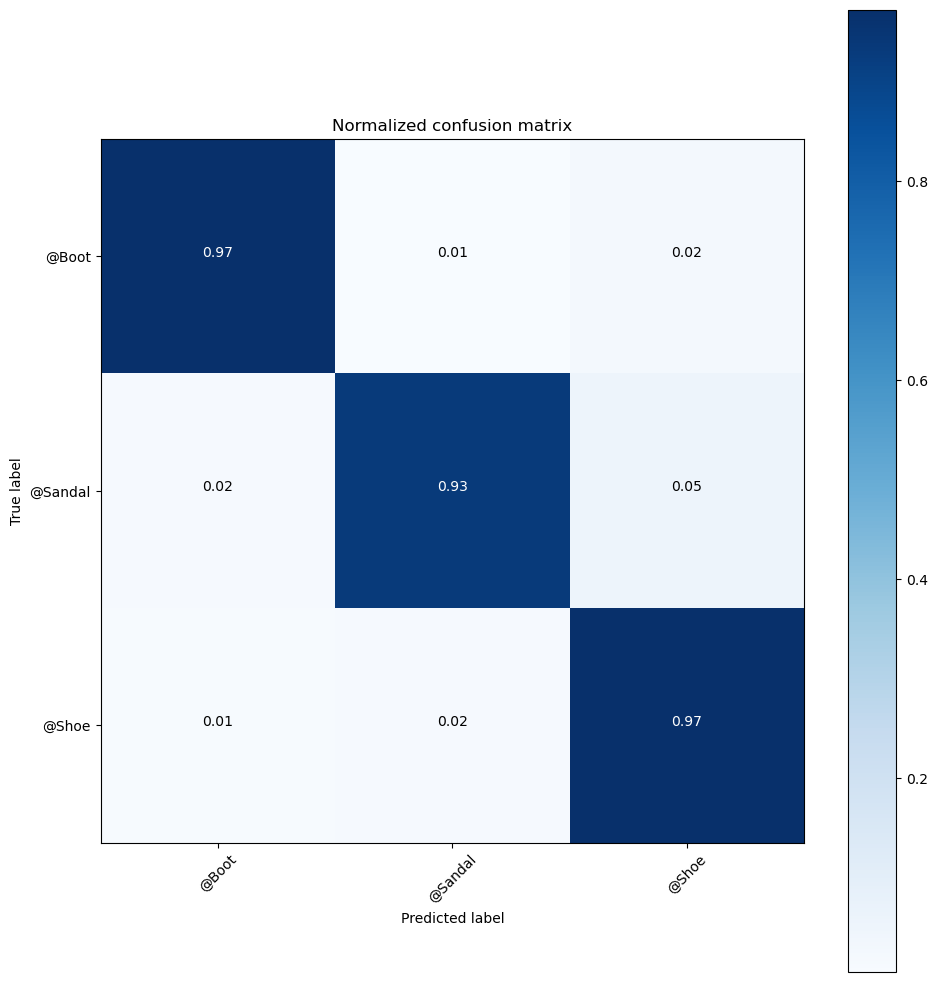

In [54]:
print('The accuracy of the test is: ', accuracy_score(y_test,y_pred))

precision_macro = precision_score(y_test, y_pred,average = 'macro')
print("The macro precision is: ", precision_macro)

precision_micro = precision_score(y_test, y_pred,average = 'micro')
print("The micro precision is: ", precision_micro)

recall = recall_score(y_test, y_pred, average = 'macro')
print("The macro recall is: ", recall)

recall = recall_score(y_test, y_pred, average = 'micro')
print("The micro recall is: ", recall)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

By using factorization of kernels, the number of parameters of the network decreases and its nonlinearity increases. Compared to part A, we have fewer parameters in this network model